In [2]:
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio.v2 as imageio
from tensorflow.keras import layers
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import random

Lets first take a look at the images. Because the images are all separated into separate folders, we can use glob to get all the images.

In [3]:
#Desktop
images = glob.glob('../data/data*/data*/CameraRGB/*.png')
masks = glob.glob('../data/data*/data*/CameraSeg/*.png')
#Laptop
#images = glob.glob('../data/data*/CameraRGB/*.png')
#masks = glob.glob('../data/data*/CameraSeg/*.png')

Here we can see the side by side of the images and masks supplied by the dataset. 

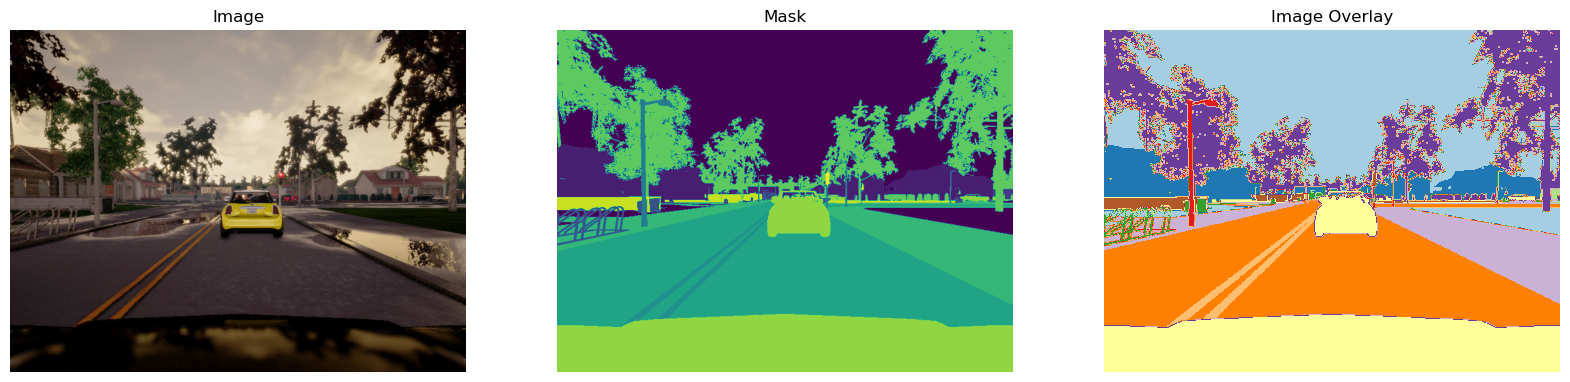

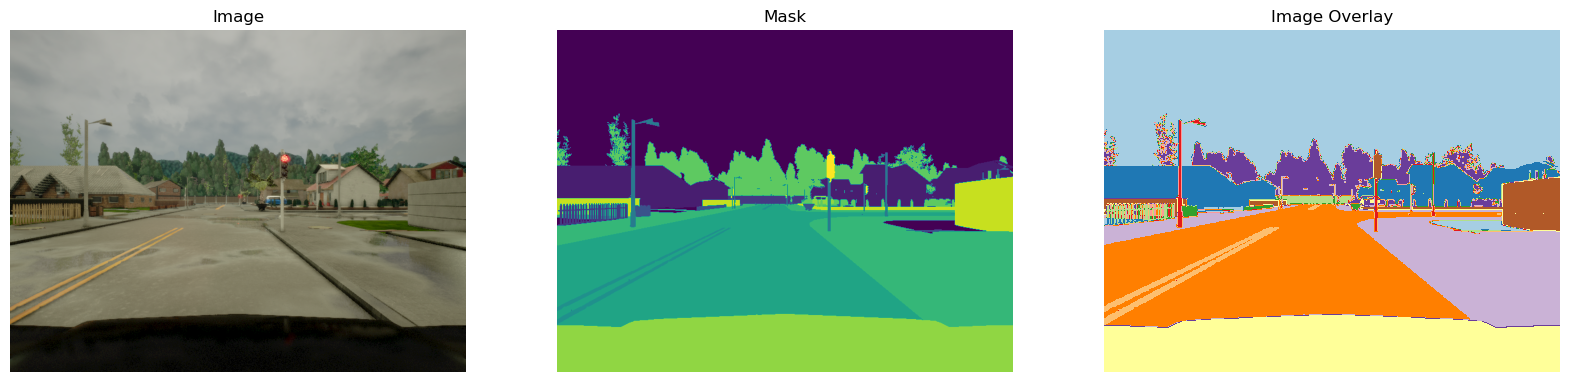

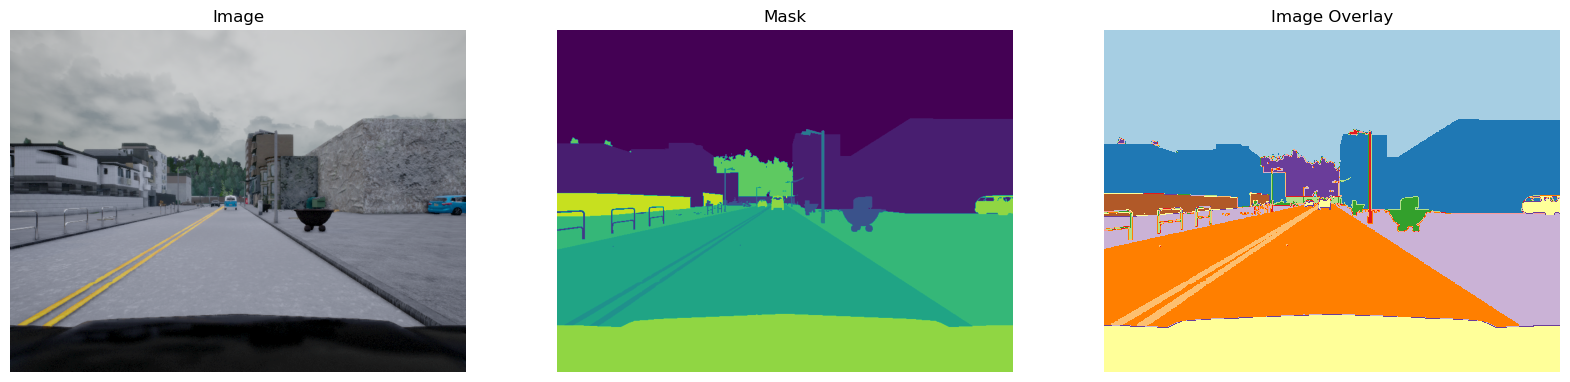

In [4]:
for i in range(3):
    N = random.randint(0, len(images) - 1)

    img = imageio.imread(images[N])
    mask = imageio.imread(masks[N])
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Mask')
    arr[1].axis("off")    
    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Image Overlay')
    arr[2].axis("off")

Now we will load in all the images with tensorflow and store it in a tensorflow dataset. We will create some helper functions so that they can be mapped to a tensorflow dataset

In [5]:
def get_dataset(batch_size, buffer_size, img_paths, mask_paths):
    def load_imgs(img_path, mask_path):
        input_img = tf_io.read_file(img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf.image.convert_image_dtype(input_img, tf.float32)
        input_img = tf.image.resize(input_img, (256, 256), method='nearest')

        input_mask = tf_io.read_file(mask_path)
        input_mask = tf_io.decode_png(input_mask, channels=3)
        input_mask = tf.math.reduce_max(input_mask, axis=-1, keepdims=True)
        input_mask = tf.image.resize(input_mask, (256, 256), method='nearest')

        return input_img, input_mask
    image_list = tf.constant(img_paths)
    mask_list = tf.constant(mask_paths)
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_imgs, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.cache().shuffle(buffer_size).batch(batch_size)

Before we go ahead with the model, we will first create a validation split so we can see some metrics while the model runs

In [6]:
val_samples = 1000
#N = random.randint(0, val_samples)
#random.Random(N).shuffle(images)
#random.Random(N).shuffle(masks)
train_img_paths = images[:-val_samples]
train_mask_paths = masks[:-val_samples]
val_img_paths = images[-val_samples:]
val_mask_paths = masks[-val_samples:]

#Small sample for fast testing
#train_img_paths = images[:1000]
#train_mask_paths = masks[:1000]
#val_img_paths = images[-400:]
#val_mask_paths = masks[-400:]

train_data = get_dataset(32, 500, train_img_paths, train_mask_paths)
val_data = get_dataset(32, 500, val_img_paths, val_mask_paths)

Here we will create some functions so that we can see how the model's predicted masks compare with the validation masks

In [7]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(in_model, dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = in_model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

We can test this function quickly to see if it is working properly, and it is.

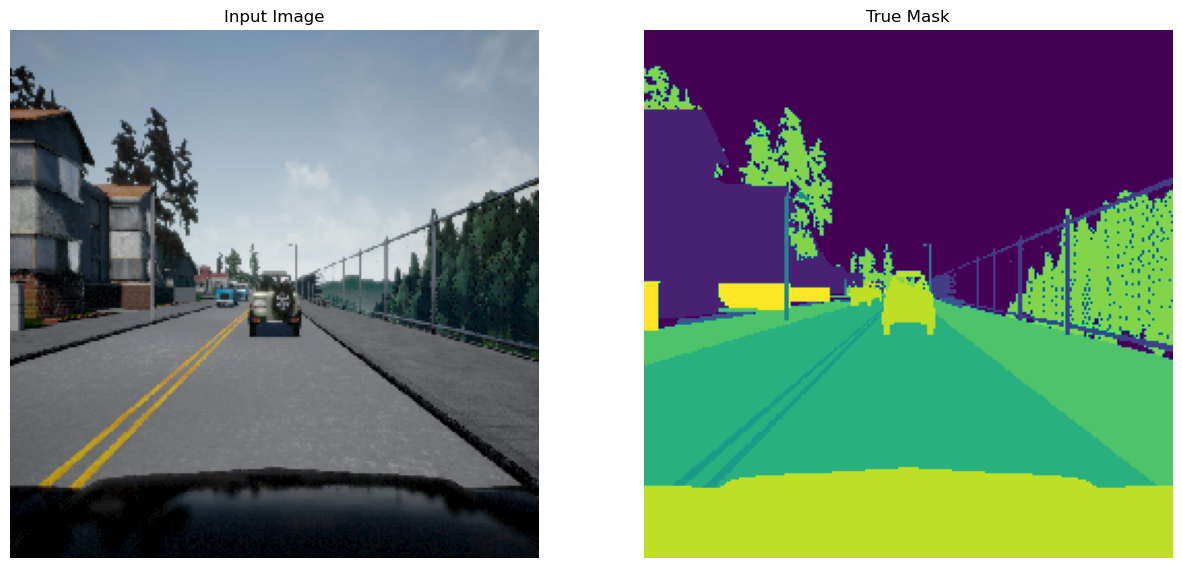

In [8]:
for image,mask in train_data.take(1):
    display([image[0], mask[0]])

# First model
Next we'll create a U-Net model where the model first downsamples the inputs before upsampling them back for predictions. We will start off with a model that is not too complex. First we'll define some functions that will help with model creation

In [39]:
def conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.2)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    #Ensures dimension match before concatenation
    target_shape = tf.shape(x)[1:3]
    conv_features = tf.image.resize(conv_features, target_shape)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.2)(x)
    x = conv_block(x, n_filters)
    return x

Now we will create the model

In [40]:
inputs = layers.Input(shape=(256,256,3))

f1, p1 = downsample_block(inputs, 64)
f2, p2 = downsample_block(p1, 128)
f3, p3 = downsample_block(p2, 256)
f4, p4 = downsample_block(p3, 512)

bottleneck = conv_block(p4, 1024)

u6 = upsample_block(bottleneck, f4, 512)
u7 = upsample_block(u6, f3, 256)
u8 = upsample_block(u7, f2, 128)
u9 = upsample_block(u8, f1, 64)

conv10 = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(u9)
outputs = layers.Conv2D(13, 1, padding='same')(conv10)

unet_model = tf.keras.Model(inputs, outputs)

In [28]:
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(13)])
#callback = tf.keras.callbacks.ModelCheckpoint('model1.keras', save_best_only=True)
lr_decrease = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)

We will test on only 10 epochs just to get a quick glance at the performance of the model. We can see that it is actually performing decently well for a relatively simple model. Accuracy isn't the best metric for this model, but still it is decently high.

In [42]:
model1_hist = unet_model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[lr_decrease])

Epoch 1/10
125/125 [==============================] - 96s 761ms/step - loss: 2.7351 - accuracy: 0.2029 - val_loss: 2.0066 - val_accuracy: 0.1712 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 88s 700ms/step - loss: 1.8773 - accuracy: 0.3045 - val_loss: 1.6084 - val_accuracy: 0.4524 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 89s 712ms/step - loss: 1.5674 - accuracy: 0.4908 - val_loss: 1.4666 - val_accuracy: 0.5395 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 88s 703ms/step - loss: 1.3469 - accuracy: 0.5904 - val_loss: 1.2688 - val_accuracy: 0.6120 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 88s 702ms/step - loss: 1.1588 - accuracy: 0.6498 - val_loss: 1.0414 - val_accuracy: 0.6781 - lr: 1.0000e-04
Epoch 6/10
125/125 [==============================] - 88s 701ms/step - loss: 0.9977 - accuracy: 0.7036 - val_loss: 1.1138 - val_accuracy: 0.7171 - lr: 1.0000e-04
Epoch 7/10
125/125 [========

Here we will save the model so that we do not have to rerun the fit every time

In [44]:
unet_model.save('./models/model1.keras')

While the mask isn't perfect, it's doing surprisingly well for a first model. The outlines of the objects aren't as sharp as the true mask, but it is clearly marking larger objects. It can pretty clearly classify the front of the user's car, and most of the road, but it struggles with trees, cars, and pretty much everything else. Still, this is a solid first model and there is a lot we can change with the model to improve it.

1/1 [==============================] - 10s 10s/step


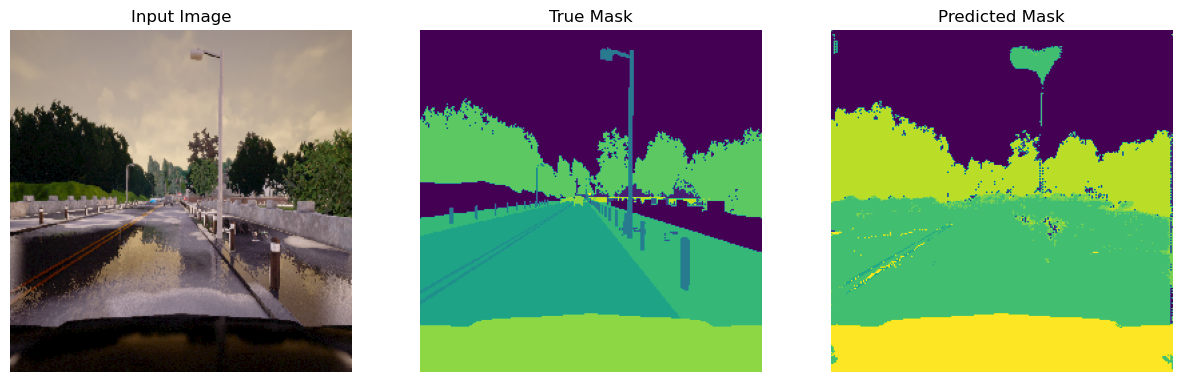

1/1 [==============================] - 9s 9s/step


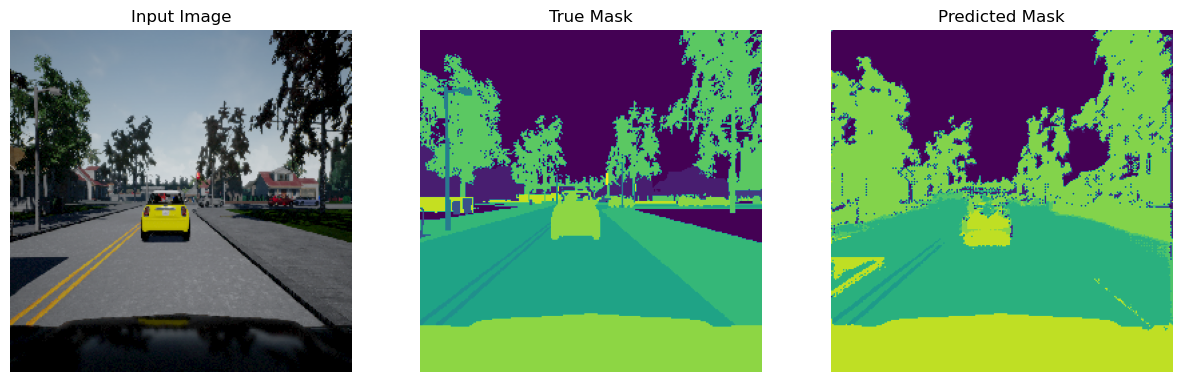

In [9]:
unet_model = tf.keras.models.load_model('./models/model1.keras')
show_predictions(unet_model, train_data, 2)

# Simpler upsampling layer
Here we will change some things with the original model that may improve the performance. For one, we will remove the dropout rounds as those might be hurting the upsampling. We will also change the Conv2DTranspose into an UpSampling2D layer, which is a simpler method of scaling and should be faster. In order to properly replace Conv2DTranspose, we will need to insert a Conv2D layer after the upsampling in order to still learn from it. It may not necessarily be better, but it is worth a shot. We will also add a BatchNormalization layer within the convolution block during downsampling to aid the model.

In [51]:
def conv2_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(3)(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(3)(x)
    return x

def downsample2_block(x, n_filters):
    f = conv2_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    return f, p

def upsample2_block(x, conv_features, n_filters):
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.concatenate([x, conv_features], axis=3)
    x = conv2_block(x, n_filters)
    return x

We will also add a softmax activation for the final convolutional layer

In [52]:
inputs = layers.Input(shape=(256,256,3))

f1, p1 = downsample2_block(inputs, 64)
f2, p2 = downsample2_block(p1, 128)
f3, p3 = downsample2_block(p2, 256)
f4, p4 = downsample2_block(p3, 512)

bottleneck = conv2_block(p4, 1024)

u6 = upsample2_block(bottleneck, f4, 512)
u7 = upsample2_block(u6, f3, 256)
u8 = upsample2_block(u7, f2, 128)
u9 = upsample2_block(u8, f1, 64)

conv = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(u9)
outputs = layers.Conv2D(13, 1, padding='same', activation='softmax')(conv)

unet2_model = tf.keras.Model(inputs, outputs)

In [53]:
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet2_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#callback = tf.keras.callbacks.ModelCheckpoint('model2.keras', save_best_only=True)
lr_decrease = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)

In [54]:
model2_hist = unet2_model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[lr_decrease])

Epoch 1/10
125/125 [==============================] - 124s 986ms/step - loss: 0.4410 - accuracy: 0.8674 - val_loss: 3.1912 - val_accuracy: 0.5776 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 124s 992ms/step - loss: 0.2091 - accuracy: 0.9342 - val_loss: 2.4035 - val_accuracy: 0.6330 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 125s 997ms/step - loss: 0.1590 - accuracy: 0.9491 - val_loss: 1.5188 - val_accuracy: 0.7178 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 124s 996ms/step - loss: 0.1345 - accuracy: 0.9566 - val_loss: 0.6644 - val_accuracy: 0.8353 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 125s 997ms/step - loss: 0.1177 - accuracy: 0.9614 - val_loss: 0.1727 - val_accuracy: 0.9443 - lr: 0.0010
Epoch 6/10
125/125 [==============================] - 124s 996ms/step - loss: 0.1271 - accuracy: 0.9586 - val_loss: 0.1088 - val_accuracy: 0.9640 - lr: 0.0010
Epoch 7/10
125/125 [==========================

The accuracy did not get as high as the initial model, and we can see from the mask that it is actually performing considerably worse. It is not clear what the different objects are, and many things are being blended together, which is not a desired effect. This may be because we changed the Con2dTranspose to an Upsampling2D layer so we will go back to the transpose layer for the next model, and make it more complex.

In [55]:
unet2_model.save('./models/model2.keras')

1/1 [==============================] - 13s 13s/step


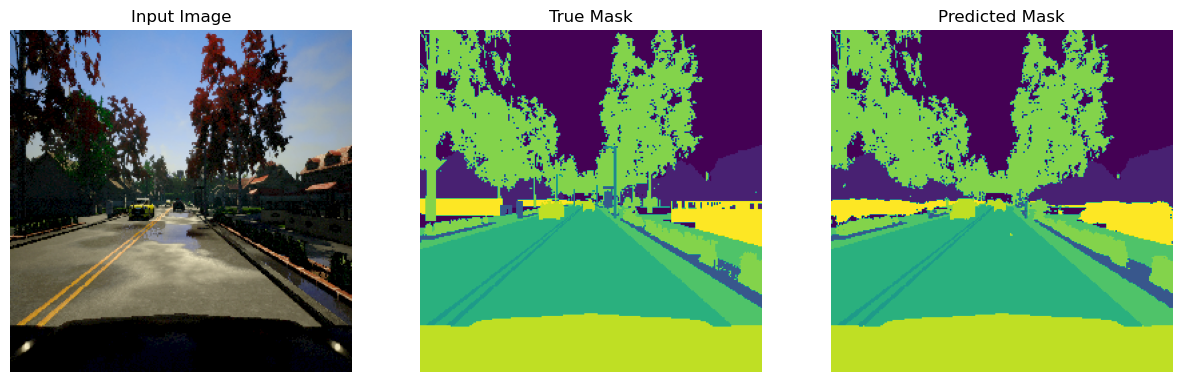

1/1 [==============================] - 12s 12s/step


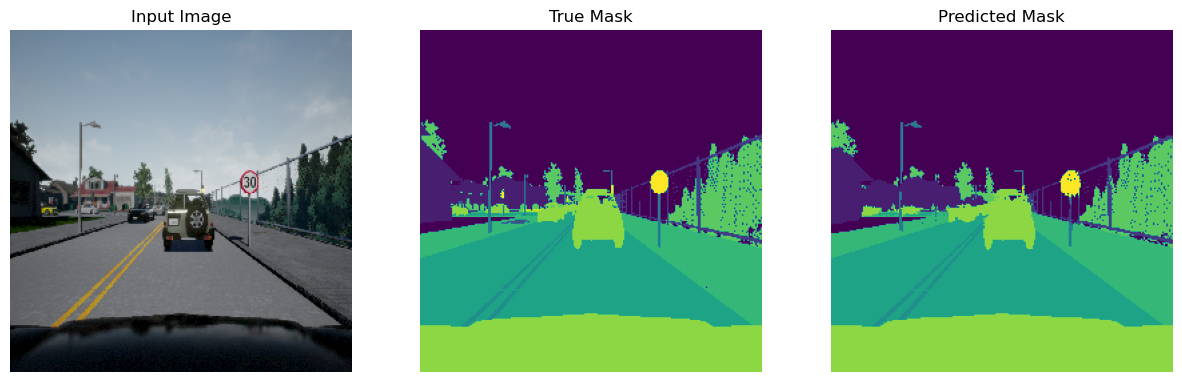

In [9]:
unet2_model = tf.keras.models.load_model('./models/model2.keras')
show_predictions(unet2_model, train_data, 2)

# Third model
We will aim to make the model do the most in this step. First, we will add an activation layer inside the convolutional block, and use LeakyReLU as opposed to normal ReLU, which helps deal with exploding/disappearing gradients. We will also add batch normalization and activation after the upsampling in hopes that it will help performance.

In [60]:
def conv3_block(x, n_filters, dropout=0):
    x = layers.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(3)(x, training=True)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(3)(x, training=True)
    x = layers.LeakyReLU()(x)
    if dropout>0:
        x = layers.Dropout(dropout)(x)
    return x

def downsample3_block(x, n_filters, dropout=0):
    f = conv3_block(x, n_filters, dropout)
    p = layers.MaxPooling2D(2)(f)
    return f, p

def upsample3_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same', kernel_initializer='he_normal')(x)
    x = layers.concatenate([x, conv_features], axis=3)
    x = conv3_block(x, n_filters)
    return x

In [61]:
inputs = layers.Input(shape=(256,256,3))

f1, p1 = downsample3_block(inputs, 64)
f2, p2 = downsample3_block(p1, 128)
f3, p3 = downsample3_block(p2, 256)
f4, p4 = downsample3_block(p3, 512, dropout=0.3)

bottleneck = conv3_block(p4, 1024, dropout=0.3)

u6 = upsample3_block(bottleneck, f4, 512)
u7 = upsample3_block(u6, f3, 256)
u8 = upsample3_block(u7, f2, 128)
u9 = upsample3_block(u8, f1, 64)

layer = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(u9)
layer = layers.BatchNormalization(3)(layer, training=True)
layer = layers.LeakyReLU()(layer)
outputs = layers.Conv2D(13, 1, padding='same')(layer)
layer = layers.BatchNormalization(3)(layer, training=True)
outputs = layers.Softmax()(layer)

#outputs = layers.Conv2D(13, 1, padding='same')(conv10)

unet3_model = tf.keras.Model(inputs, outputs)

In [62]:
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet3_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#callback = tf.keras.callbacks.ModelCheckpoint('model3.keras', save_best_only=True)
lr_decrease = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=True, min_lr=1e-6)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True , patience=3, verbose=1)

In [63]:
model3_hist = unet3_model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[lr_decrease, early_stop])

Epoch 1/10
125/125 [==============================] - 119s 941ms/step - loss: 2.2591 - accuracy: 0.7969 - val_loss: 1.8181 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 118s 947ms/step - loss: 1.5905 - accuracy: 0.9129 - val_loss: 1.3886 - val_accuracy: 0.9277 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 119s 952ms/step - loss: 1.2311 - accuracy: 0.9342 - val_loss: 1.0942 - val_accuracy: 0.9387 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 119s 952ms/step - loss: 0.9600 - accuracy: 0.9467 - val_loss: 0.8624 - val_accuracy: 0.9472 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 119s 952ms/step - loss: 0.7633 - accuracy: 0.9532 - val_loss: 0.6824 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 6/10
125/125 [==============================] - 119s 952ms/step - loss: 0.6154 - accuracy: 0.9581 - val_loss: 0.5544 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 7/10
125/125 [==========================

In [64]:
unet3_model.save('./models/model3.keras')

1/1 [==============================] - 11s 11s/step


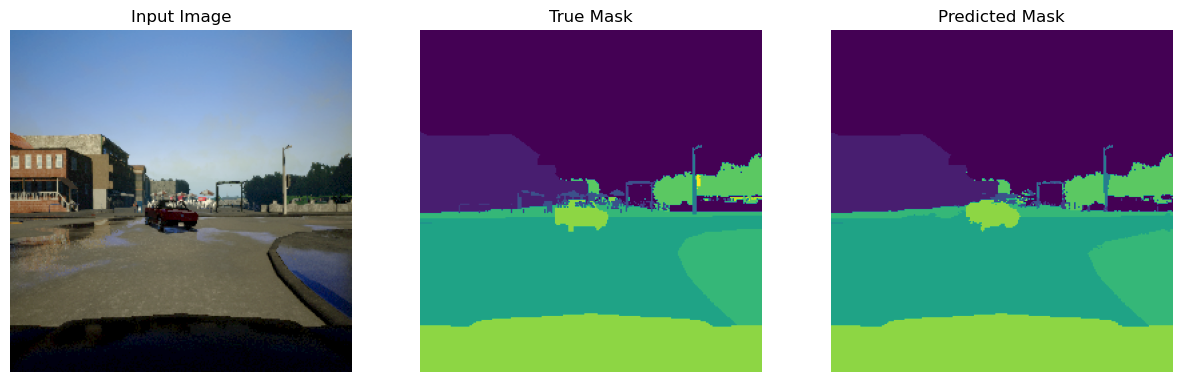

1/1 [==============================] - 11s 11s/step


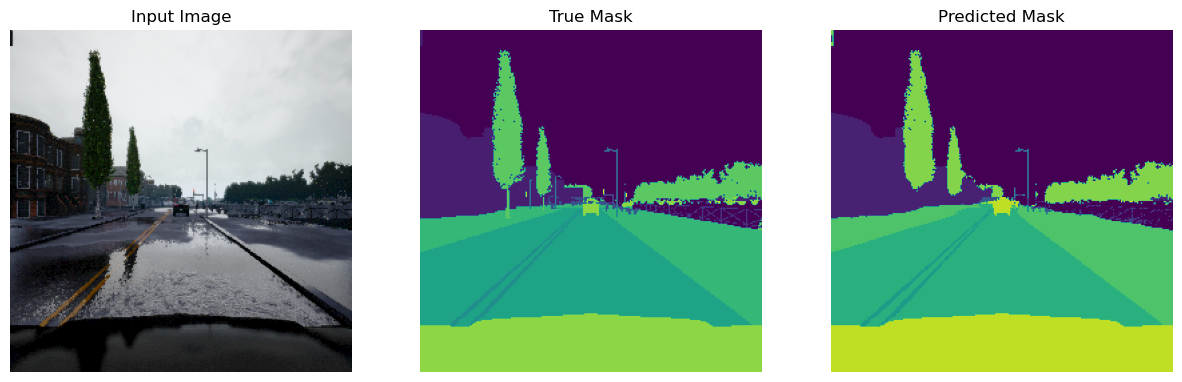

In [10]:
unet3_model = tf.keras.models.load_model('./models/model3.keras')
show_predictions(unet3_model, val_data, 2)

# Exploring metrics
We will first look at the accuracy metrics of the three models graphed side by side since that was the only one recorded by the models. We will then look at more relevant metrics for semantic segmentation such as IoU and Dice coefficient

In [18]:
val_loss, val_accuracy = unet_model.evaluate(val_data)

32/32 [==============================] - 274s 9s/step - loss: 0.7592 - accuracy: 0.7551


In [22]:
y_pred = unet_model.predict(val_data)

32/32 [==============================] - 263s 8s/step


TypeError: float() argument must be a string or a number, not 'dict'

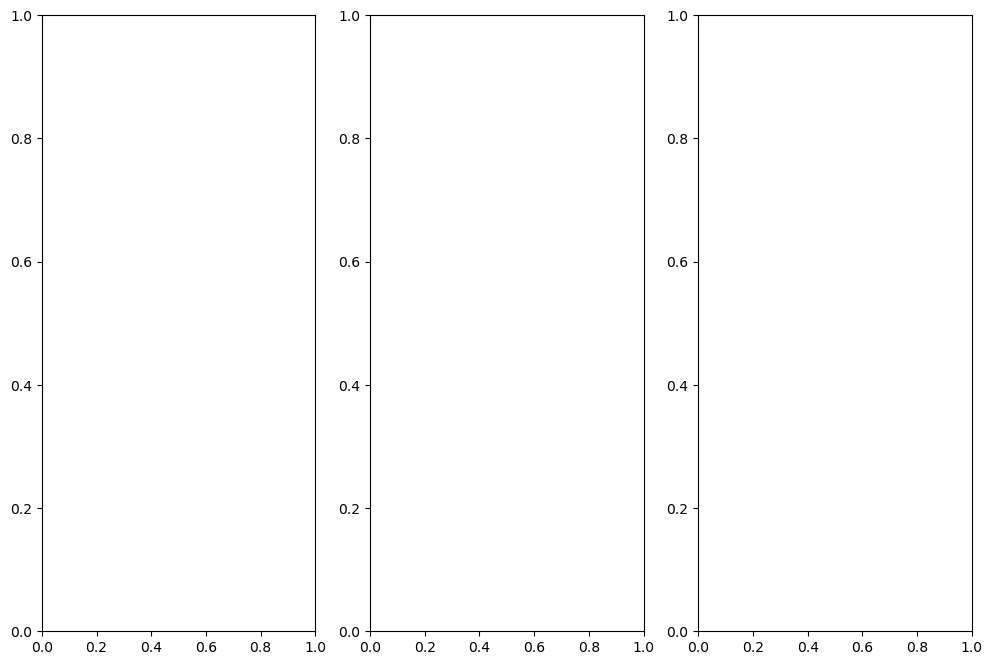

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 8))
ax[0].plot(unet_model.history.history)

In [19]:
def iou_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-7)

In [ ]:
y_bin = np.argmax(y_pred, axis=-1)
iou_score(val_data, y_bin)

TypeError: unsupported operand type(s) for *: 'BatchDataset' and 'int'